In [44]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [54]:
# Load the EMNIST dataset
(emnist_train, emnist_test), dataset_info = tfds.load('emnist', split=['train', 'test'], shuffle_files=True, with_info=True, as_supervised=True)

In [ ]:
dataset_info

In [55]:
# Create the original and new VIN labels
original_labels = list(range(10)) + [i for i in range(10, 36) if i not in [18, 24, 26]]
new_labels = list(range(33))

# Create a lookup table
table = tf.lookup.StaticHashTable(
    initializer=tf.lookup.KeyValueTensorInitializer(
        keys=tf.constant(original_labels, dtype=tf.int64),
        values=tf.constant(new_labels, dtype=tf.int64),
    ),
    default_value=tf.constant(-1, dtype=tf.int64), # ensure the default value is of dtype int64
    name="class_mapping"
)

def filter_data(images, labels):
    # Remap the labels
    labels = table.lookup(labels)

    # Check if the element is a VIN character
    return labels != -1

# Filter the data to keep only the VIN characters
emnist_train = emnist_train.filter(filter_data)
emnist_test = emnist_test.filter(filter_data)

def preprocess_data(images, labels):
    # Convert the images to float32 and normalize
    images = tf.cast(images, tf.float32) / 255.0

    # Remap the labels (again, but this time they are already filtered)
    labels = table.lookup(labels)

    # Convert labels to one-hot vectors
    labels = tf.one_hot(labels, depth=33)

    return images, labels

# Preprocess the data
emnist_train = emnist_train.map(preprocess_data, num_parallel_calls=tf.data.experimental.AUTOTUNE)
emnist_test = emnist_test.map(preprocess_data, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [60]:
model = tf.keras.Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(33, activation='softmax'),
])

In [61]:
# Compile the model
model.compile(
    optimizer='adam',  # You can use other optimizers like 'sgd', 'rmsprop', etc.
    loss='categorical_crossentropy',  # Use this loss function for multi-class classification
    metrics=['accuracy']  # You can include other metrics like 'precision', 'recall', etc.
)

# Define some parameters
epochs = 3  # The number of times to iterate over the entire dataset
batch_size = 128  # The number of samples per gradient update

# Fit the model to the data
history = model.fit(
    emnist_train.batch(batch_size),  # The input data (you can also use numpy arrays)
    epochs=epochs,  # The number of epochs
    validation_data=emnist_test.batch(batch_size),  # The validation data
)

Epoch 1/3
3863/3863 [==============================] - 586s 151ms/step - loss: 0.3471 - accuracy: 0.8995 - val_loss: 0.1119 - val_accuracy: 0.9655
Epoch 2/3
3863/3863 [==============================] - 578s 149ms/step - loss: 0.1707 - accuracy: 0.9499 - val_loss: 0.0935 - val_accuracy: 0.9712
Epoch 3/3
3863/3863 [==============================] - 566s 147ms/step - loss: 0.1392 - accuracy: 0.9591 - val_loss: 0.0834 - val_accuracy: 0.9741


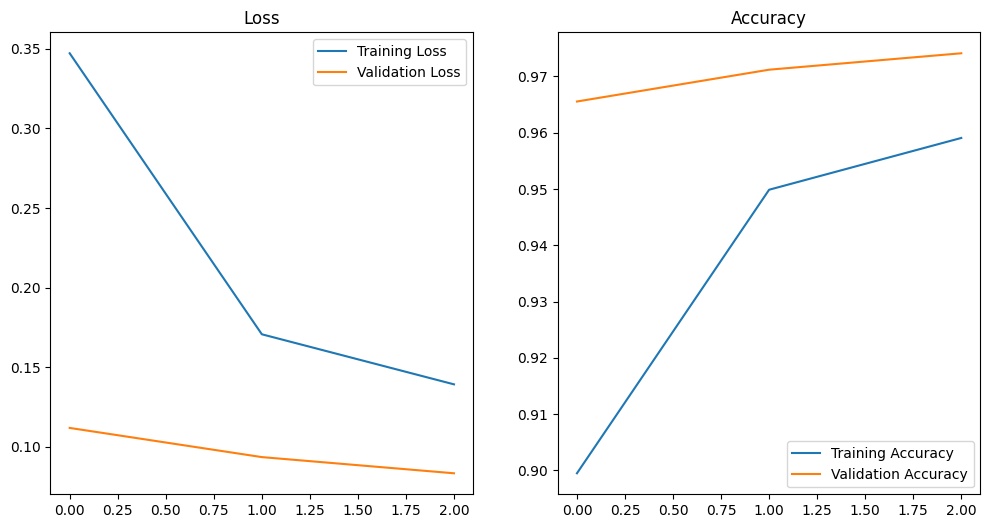

In [62]:
import matplotlib.pyplot as plt

# Plot the loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

# Plot the accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()

In [64]:
test_loss, test_accuracy = model.evaluate(emnist_test.batch(batch_size))
f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}'

646/646 [==============================] - 35s 54ms/step - loss: 0.0834 - accuracy: 0.9741


'Test Loss: 0.08339166641235352, Test Accuracy: 0.9741067290306091'

In [65]:
# Save the model
model.save('model.h5')

In [101]:
from IPython.display import HTML, Image
from google.colab.output import eval_js
from base64 import b64decode

canvas_html = """
<canvas width=%d height=%d></canvas>
<button>Finish</button>
<script>
var canvas = document.querySelector('canvas')
var ctx = canvas.getContext('2d')
ctx.fillStyle = "black";
ctx.fillRect(0, 0, canvas.width, canvas.height);
ctx.strokeStyle = "white";
ctx.lineWidth = %d
var button = document.querySelector('button')
var mouse = {x: 0, y: 0}
canvas.addEventListener('mousemove', function(e) {
  mouse.x = e.pageX - this.offsetLeft
  mouse.y = e.pageY - this.offsetTop
})
canvas.onmousedown = ()=>{
  ctx.beginPath()
  ctx.moveTo(mouse.x, mouse.y)
  canvas.addEventListener('mousemove', onPaint)
}
canvas.onmouseup = ()=>{
  canvas.removeEventListener('mousemove', onPaint)
}
var onPaint = ()=>{
  ctx.lineTo(mouse.x, mouse.y)
  ctx.stroke()
}
var data = new Promise(resolve=>{
  button.onclick = ()=>{
    // Draw a white border around the image
    ctx.strokeStyle = "white";
    ctx.lineWidth = 15; // Choose the border width
    ctx.rect(0, 0, canvas.width, canvas.height);
    ctx.stroke();
    resolve(canvas.toDataURL('image/png'))
  }
})
</script>
"""

def draw(filename='drawing.png', w=280, h=280, line_width=10):  # Increase line_width to make the brush bolder
  display(HTML(canvas_html % (w, h, line_width)))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return len(binary)

draw()

5367

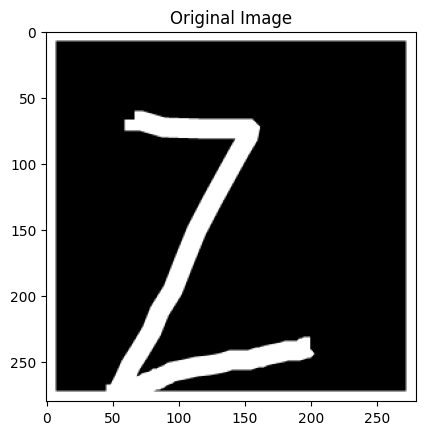

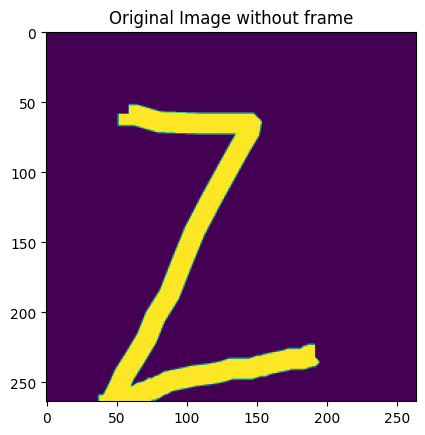

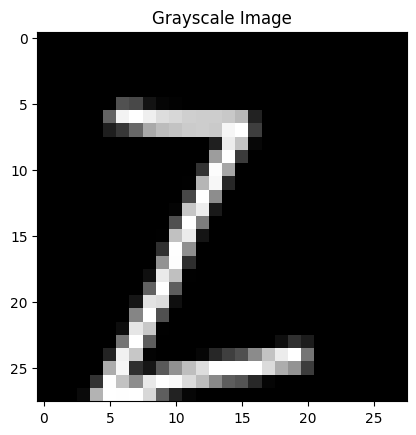

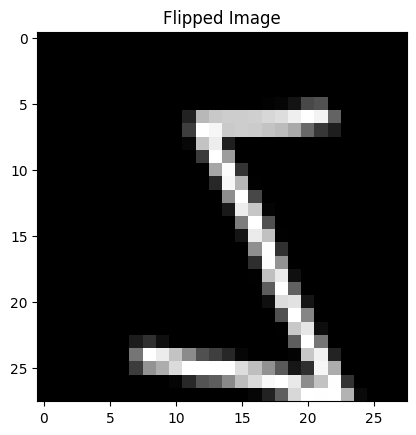

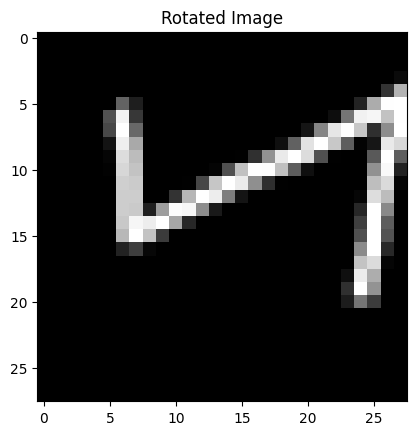

1/1 [==============================] - 0s 100ms/step
Predicted class: Z


In [102]:
from PIL import Image, ImageOps
import cv2

# Load model
model = tf.keras.models.load_model('model.h5')

def remove_frame(image):
    # Convert the image to a numpy array
    image_np = np.array(image)

    # Convert to grayscale if the image is not grayscale
    if len(image_np.shape) == 3:
        image_np = cv2.cvtColor(image_np, cv2.COLOR_BGR2GRAY)

    # Threshold the image to binary using Otsu's method
    _, image_binary = cv2.threshold(image_np, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Find contours in the binary image
    contours, _ = cv2.findContours(image_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Get the bounding box of the largest contour
    largest_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest_contour)

    # Use the bounding box to remove the frame
    image_np = image_np[y:y+h, x:x+w]

    # Convert the numpy array back to a PIL image
    image = Image.fromarray(image_np)

    return image


# Load the image
image = Image.open('drawing.png')
plt.imshow(image)
plt.title('Original Image')
plt.show()

# Remove white frame
image = remove_frame(image)
plt.imshow(image)
plt.title('Original Image without frame')
plt.show()

# Resize the image to 28x28 pixels
image = image.resize((28, 28))

# Convert the image to grayscale
image = image.convert('L')
plt.imshow(image, cmap='gray')
plt.title('Grayscale Image')
plt.show()

# Flip the image horizontally
image = image.transpose(Image.FLIP_LEFT_RIGHT)
plt.imshow(image, cmap='gray')
plt.title('Flipped Image')
plt.show()

# Rotate the image 90 degrees anticlockwise
image = image.rotate(90)
plt.imshow(image, cmap='gray')
plt.title('Rotated Image')
plt.show()


# Convert the image data to a numpy array and normalize it
image = np.array(image) / 255.0

# Check if image is not in the format (28, 28), then reshape it
if image.shape != (28, 28):
    image = image.reshape((28, 28))

# Add an extra dimension for the batch size
image_batch = np.expand_dims(image, axis=0)

# Add an extra dimension for the color channel
image_batch = np.expand_dims(image_batch, axis=-1)

# Predict the class of the image
predictions = model.predict(image_batch)

# The output is a vector of probabilities for each class
# To get the class with the highest probability, we can use argmax
predicted_class_index = np.argmax(predictions)

# Create a mapping from indices to characters
index_to_char = list('0123456789ABCDEFGHJKLMNPRSTUVWXYZ')

# Now you can use this mapping to get the predicted character
predicted_class_label = index_to_char[predicted_class_index]

print("Predicted class:", predicted_class_label)